In [1]:
import torch
import torchvision
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import PIL.Image as Image
import matplotlib.pyplot as plt

In [27]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [28]:


class ImageDataset(Dataset):
    def __init__(self, x_images, y_images, transform=None):
        self.x_paths = x_images
        self.y_paths = y_images
        self.transform = transform
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        x_path = self.x_paths[idx]
        y_path = self.y_paths[idx]
        x = Image.open(x_path).convert('RGB')
        y = Image.open(y_path).convert('RGB')
        if self.transform:
            x = transform(x)
            y = transform(y)
        return x,y

In [29]:
# Input and output folders
input_folder = '../Transformation/dogs/*'
output_folder = '../Transformation/grayscale_dogs/*'

inputs = glob.glob(input_folder)
outputs = glob.glob(output_folder)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(inputs, outputs, random_state=42, test_size=0.2)

train_dataset = ImageDataset(X_train, Y_train, transform=transform)
test_dataset = ImageDataset(X_test, Y_test, transform=transform)

In [32]:
class GrayScaleModel(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(GrayScaleModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.out = nn.Conv2d(in_channels=64, out_channels=output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(output_channels, output_channels, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = self.relu(self.conv3(x))
        x = self.upsample1(x)
        x = self.relu(self.out(x))
        x = self.upsample2(x)
        
        return x

In [33]:
model = GrayScaleModel(3,3)


In [35]:
import torch.optim as optim

num_epochs = 10

batch_size = 32

optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.train()

for epoch in range(num_epochs):
    loss_value = 0
    batch_count = 0
    for in_imgs, out_imgs in train_loader:
        optimizer.zero_grad()
        outputs = model(in_imgs)
        loss = criterion(outputs, out_imgs)
        loss.backward()
        optimizer.step()

        loss_value += loss.item() / out_imgs.size(0)

        batch_count += 1
        print(f'batch : {batch_count}')

    print(f'epoch {epoch}/{num_epochs} : loss : {loss_value}')

batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
epoch 0/10 : loss : 0.1313967081334661
batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
epoch 1/10 : loss : 0.12220398046295433
batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
epoch 2/10 : loss : 0.11345294378150035
batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
epoch 3/10 : loss : 0.10673870611935854
batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
epoch 4/10 : loss : 0.09735386303680785
batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 

In [37]:
model.eval()

with torch.no_grad():
    for in_imgs, out_imgs in test_loader:
        outputs = model(in_imgs)
        print(outputs)
        break


tensor([[[[ 0.5209,  0.5266,  0.5965,  ...,  0.7234,  0.6706,  0.6800],
          [ 0.1076,  0.5200,  0.0468,  ...,  0.7112, -0.0128,  0.6691],
          [ 0.5946,  0.6021,  0.6445,  ...,  0.8684,  0.7355,  0.7466],
          ...,
          [ 0.2494,  0.3444,  0.2041,  ...,  0.5396,  0.1143,  0.5117],
          [ 0.3307,  0.3317,  0.3659,  ...,  0.4794,  0.4232,  0.4265],
          [ 0.2606,  0.3306,  0.2322,  ...,  0.4741,  0.1861,  0.4227]],

         [[ 0.3489,  0.4698,  0.4773,  ...,  0.8972,  0.6031,  0.8030],
          [ 0.4297,  0.2980,  0.5847,  ...,  0.5813,  0.7366,  0.5188],
          [ 0.4740,  0.6338,  0.5588,  ...,  1.2121,  0.7133,  0.9475],
          ...,
          [ 0.0681,  0.0378,  0.1837,  ...,  0.3271,  0.4125,  0.2856],
          [ 0.0259,  0.0465,  0.0857,  ...,  0.3672,  0.1830,  0.2524],
          [ 0.0396,  0.0173,  0.1118,  ...,  0.2299,  0.2293,  0.1538]],

         [[ 0.4871,  0.4389,  0.6682,  ...,  0.8584,  0.8457,  0.7660],
          [ 0.4778, -0.0748,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


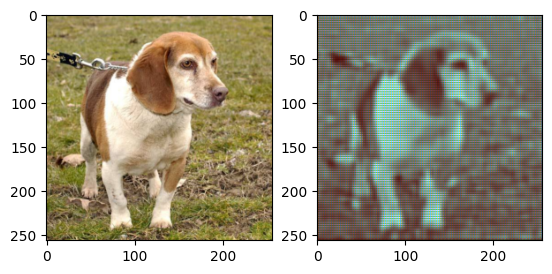

In [47]:

i = 20
pred = model(train_dataset[i][0])
input = train_dataset[i][0].permute(1,2,0).cpu().detach()
output = pred.permute(1,2,0).cpu().detach()
plt.subplot(1,2,1)
plt.imshow(input)
plt.subplot(1,2,2)
plt.imshow(output)


In [60]:
torch.save(model, 'model.pth')